In [1]:
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import numpy as np
import gzip
from scipy.optimize import curve_fit
from scipy import stats
from scipy import odr
import math
import pymc3 as pm
import theano

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\nikko\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

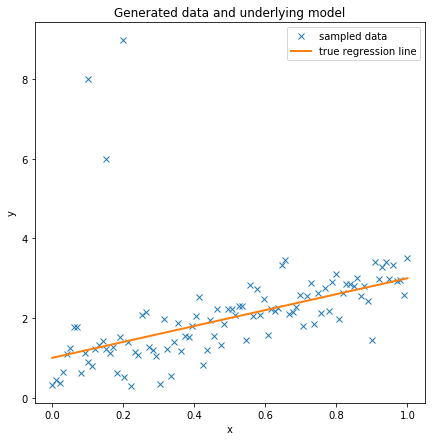

In [3]:

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [4]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 49 seconds.


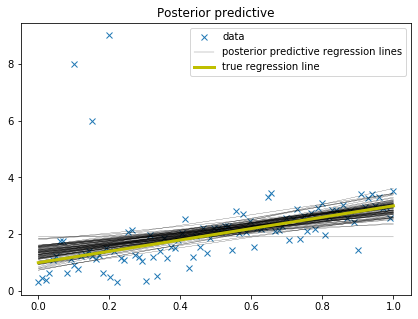

In [5]:
plt.figure(figsize=(7, 5))
plt.plot(x_out, y_out, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')

plt.legend(loc=0);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 60 seconds.


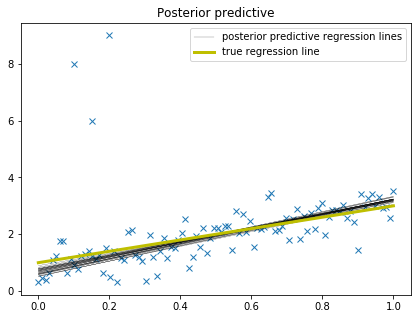

In [6]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(2000, cores=2)

plt.figure(figsize=(7, 5))
plt.plot(x_out, y_out, 'x')
pm.plot_posterior_predictive_glm(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')
plt.legend();

In [7]:
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 16
plt.rcParams['xtick.minor.size'] = 9
plt.rcParams['ytick.major.size'] = 16
plt.rcParams['ytick.minor.size'] = 9
plt.rcParams['ytick.minor.size'] = 9
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.minor.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.minor.width'] = 2.5
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.pad'] = 9
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams.update({'font.size': 30})

In [8]:
pabdatazcut = fits.open('pabdatazcut.fits')
sortedpab = sorted(pabdatazcut[1].data , key = lambda data: data['PAB_FLUX'] , reverse = True )

data_dict= dict()
for obj in sortedpab:
    for key in ['FIELD', 'ID', 'RA', 'DEC' , 'Z_50', 'Z_84','Z_16' , 'PAB_FLUX', 'PAB_FLUX_ERR']:
        data_dict.setdefault(key, list()).append(obj[key])

sortedpabdf = pd.DataFrame(data_dict)
sortedpabdf['Z_ERR']= ((sortedpabdf['Z_84'] - sortedpabdf['Z_50']) + (sortedpabdf['Z_50'] - sortedpabdf['Z_16'])) / (2 * sortedpabdf['Z_50'])
sortedpabdf['OBS_PAB'] = 12820 * (1 + sortedpabdf['Z_50'])
sortedpabdf.loc[sortedpabdf['FIELD'] == "ERS" , 'FIELD'] = "ERSPRIME"
sortedpabdf = sortedpabdf[['FIELD' , 'ID' , 'RA' , 'DEC' , 'Z_50' , 'Z_ERR' , 'PAB_FLUX' , 'PAB_FLUX_ERR' , 'OBS_PAB']]

In [9]:
good = [6 , 9 , 12 , 14 , 15 , 18 , 21 , 24 , 29 , 30 , 35 , 36 , 37 , 46 , 48 , 51 , 52 , 55 , 58 , 70 , 71 , 72 , 74 , 75 , 78 , 80 , 81 , 84 , 89 , 97 , 98 , 102 ,  112 , 118 , 119 , 120 , 125 , 126 , 128 , 129 , 132 , 138 , 147 , 148 , 150 , 158 , 159 , 160 , 163 , 166 , 181 , 184 , 186 , 189 , 193 , 194 , 196 , 206 , 213 , 215 , 235 , 244 , 257 , 259 , 265 , 275 , 280 , 284 , 285 , 290 , 306 , 319 , 326 , 339 , 347 , 365 ]
gooddf50 = sortedpabdf.loc[good]

GNdf = gooddf50[gooddf50['FIELD'] == 'GN1']
GNdf = GNdf.append(gooddf50[gooddf50['FIELD'] == 'GN2'])
GNdf = GNdf.append(gooddf50[gooddf50['FIELD'] == 'GN3'])
GNdf = GNdf.append(gooddf50[gooddf50['FIELD'] == 'GN4'])
GNdf = GNdf.append(gooddf50[gooddf50['FIELD'] == 'GN5'])
GNdf = GNdf.append(gooddf50[gooddf50['FIELD'] == 'GN7'])
GNdf = GNdf[GNdf.ID != 38114]
GNdf = GNdf[GNdf.ID != 21829]
GNdf = GNdf[GNdf.ID != 22158]
GNdf = GNdf[GNdf.ID != 25434]
GNdf = GNdf[GNdf.ID != 35356]
GNdf = GNdf[GNdf.ID != 19075]
GNdf = GNdf[GNdf.ID != 22583]
GNdf = GNdf[GNdf.ID != 22933]
GNdf = GNdf[GNdf.ID != 26542]
GNdf = GNdf[GNdf.ID != 33015]
GNdf = GNdf[GNdf.ID != 37721]
GNdf = GNdf[GNdf.ID != 32992]
GNdf = GNdf[GNdf.ID != 36624]

GSdf = gooddf50[gooddf50['FIELD'] == 'GS1']
GSdf = GSdf.append(gooddf50[gooddf50['FIELD'] == 'GS2'])
GSdf = GSdf.append(gooddf50[gooddf50['FIELD'] == 'GS3'])
GSdf = GSdf.append(gooddf50[gooddf50['FIELD'] == 'GS4'])
GSdf = GSdf.append(gooddf50[gooddf50['FIELD'] == 'GS5'])
GSdf = GSdf.append(gooddf50[gooddf50['FIELD'] == 'ERSPRIME'])
GSdf = GSdf[GSdf.ID != 39505]
GSdf = GSdf[GSdf.ID != 41397]
GSdf = GSdf[GSdf.ID != 43823]
GSdf = GSdf[GSdf.ID != 43401]
GSdf = GSdf[GSdf.ID != 36971]
GSdf = GSdf[GSdf.ID != 26915]
GSdf = GSdf[GSdf.ID != 37739]
GSdf = GSdf[GSdf.ID != 36001]
GSdf = GSdf[GSdf.ID != 42866]
GSdf = GSdf[GSdf.ID != 39042]
GSdf = GSdf[GSdf.ID != 44831]
GSdf = GSdf[GSdf.ID != 44959]
GSdf = GSdf[GSdf.ID != 34363]
GSdf = GSdf[GSdf.ID != 36624]
GSdf = GSdf[GSdf.ID != 20623]
GSdf = GSdf[GSdf.ID != 24491]
GSdf = GSdf[GSdf.ID != 43700]

fulldf = pd.concat([GNdf , GSdf])
fulldf['DL'] = cosmo.luminosity_distance(fulldf['Z_50'])

#display(fulldf)
#print(len(fulldf))


In [10]:
GNtable = Table.read('D:/GOODSN.hdf5', path = 'data') 
GStable = Table.read('D:/GOODSS.hdf5', path = 'data')

data_dictn= dict()
for obj in GNtable:
    for key in ['id3DHST' , 'RA', 'DEC', 'ir_SFR-ladder_total' , 'ir_SFR-ladder_total_Av' ,'gf_n_j', 'gf_dn_j' , 'gf_f_j' , 'gf_re_j' , 'gf_dre_j' , 'td_Av', 'ACS_F435W_FLUX' , 'ACS_F775W_FLUX' , 'restalt_restUjohnson' , 'restalt_restVjohnson'  , 'td_flag1' , 'td_z_best' , 'td_z_spec' , 'td_z_best_s' , 'td_z_peak_phot' ,'td_lmass', 'td_sfr' , 'td_sfr_IR' , 'td_sfr_UV', 'ir_z_ir' ,'ir_SFR-UV_corr' , 'ir_SFR-UV_corr_Error','ir_SFR-IR', 'ir_UV_beta']:
        data_dictn.setdefault(key, list()).append(obj[key])

GNtabledf = pd.DataFrame(data_dictn)
GNtabledf = GNtabledf[GNtabledf['td_z_best'] <= .31]
GNtabledf = GNtabledf[GNtabledf['td_z_best'] >= .1]
data_dicts= dict()
for obj in GStable:
    for key in ['id3DHST' , 'RA', 'DEC', 'ir_SFR-ladder_total' , 'ir_SFR-ladder_total_Av' , 'gf_n_j', 'gf_dn_j' , 'gf_f_j' , 'gf_re_j' , 'gf_dre_j' , 'td_Av' , 'ACS_F435W_FLUX' , 'ACS_F775W_FLUX' , 'restUjohnson' , 'restVjohnson' , 'td_flag1' , 'td_z_best' , 'td_z_spec', 'td_z_best_s', 'td_z_peak_phot', 'td_lmass' , 'td_sfr' , 'td_sfr_IR' , 'td_sfr_UV' , 'ir_z_ir' , 'ir_SFR-UV_corr', 'ir_SFR-UV_corr_Error', 'ir_SFR-IR', 'ir_UV_beta']:
        data_dicts.setdefault(key, list()).append(obj[key])

GStabledf = pd.DataFrame(data_dicts)
GStabledf = GStabledf[GStabledf['td_z_best'] <= .31]

#display(GStabledf)
#display(GNtabledf)

In [11]:
idmergedf = pd.merge(GNdf, GNtabledf , how = 'inner' , left_on = 'ID' , right_on = 'id3DHST')
idmergedf.drop('RA_y', axis=1, inplace=True)
idmergedf.drop('DEC_y', axis=1, inplace=True)
idmergedf['DL'] = cosmo.luminosity_distance(idmergedf['Z_50'])
idmergedf['PAB_L'] = idmergedf['PAB_FLUX'] * 4 * np.pi * idmergedf['DL']**2 * 9.521 * 10**(48) * 10**(-17)
idmergedf['PAB_L_ERR'] = idmergedf['PAB_FLUX_ERR'] * 4 * np.pi * idmergedf['DL']**2 * 9.521 * 10**(48) * 10**(-17)

idmergedfs = pd.merge(GSdf, GStabledf , how = 'inner' , left_on = 'ID' , right_on = 'id3DHST')
idmergedfs.drop('RA_y', axis=1, inplace=True)
idmergedfs.drop('DEC_y', axis=1, inplace=True)
idmergedfs['DL'] = cosmo.luminosity_distance(idmergedfs['Z_50'])
idmergedfs['PAB_L_ERR'] = idmergedfs['PAB_FLUX_ERR'] * 4 * np.pi * idmergedfs['DL']**2 * 9.521 * 10**(48) * 10**(-17)
idmergedfs['PAB_L'] = idmergedfs['PAB_FLUX'] * 4 * np.pi * idmergedfs['DL']**2 * 9.521 * 10**(48) * 10**(-17)
idmergedfs['restalt_restUjohnson'] = idmergedfs['restUjohnson'] 
idmergedfs['restalt_restVjohnson'] = idmergedfs['restVjohnson']

fullmergedf = pd.concat([idmergedf , idmergedfs] , sort = False)
fullmergedf.drop('restUjohnson', axis=1, inplace=True)
fullmergedf.drop('restVjohnson', axis=1, inplace=True)

fullmergedf['PAB_SFR'] = np.log10(fullmergedf['PAB_L'].astype(float)) - 40.02
fullmergedf['PAB_SFR_ERR']= .434*fullmergedf['PAB_L_ERR']/fullmergedf['PAB_L']
fullmergedf['UV_SFR_ERR']= .434*fullmergedf['ir_SFR-UV_corr_Error']/fullmergedf['ir_SFR-UV_corr']
#fullmergedf['PAB_SFR_EX'] = fullmergedf['PAB_SFR'] - fullmergedf['ir_SFR-UV_corr'] 
fullmergedf['PAB_SFR_EX2'] = fullmergedf['PAB_SFR'] - np.log10(fullmergedf['ir_SFR-UV_corr'])
fullmergedf['PAB_SFR_EX2_ERR'] = np.sqrt(fullmergedf['PAB_SFR_ERR'].astype(None)**2 + fullmergedf['UV_SFR_ERR'].astype(None)**2)
fullmergedf['PAB_SFR_LL'] = np.log10((min(fullmergedf['PAB_FLUX']) * 4 * np.pi * fullmergedf['DL']**2 * 9.521 * 10**(48) * 10**(-17)).astype(float)) - 40.02
fullmergedf['PAB_SFR_EX2_LL'] = fullmergedf['PAB_SFR_LL'] - np.log10(fullmergedf['ir_SFR-UV_corr'])
fullmergedf['PAB_SFR_LL_1SIGMA'] = np.log10((min(fullmergedf['PAB_FLUX_ERR']) * 4 * np.pi * fullmergedf['DL']**2 * 9.521 * 10**(48) * 10**(-17)).astype(float)) - 40.02
fullmergedf['PAB_SFR_EX_LL_1SIGMA'] = fullmergedf['PAB_SFR_LL_1SIGMA'] - np.log10(fullmergedf['ir_SFR-UV_corr']) 
display(fullmergedf)

,FIELD,ID,RA_x,DEC_x,Z_50,Z_ERR,PAB_FLUX,PAB_FLUX_ERR,OBS_PAB,id3DHST,...,PAB_L_ERR,PAB_SFR,PAB_SFR_ERR,UV_SFR_ERR,PAB_SFR_EX2,PAB_SFR_EX2_ERR,PAB_SFR_LL,PAB_SFR_EX2_LL,PAB_SFR_LL_1SIGMA,PAB_SFR_EX_LL_1SIGMA
0,GN1,37683,189.306089,62.360350,0.277481,0.001144,3.907847,1.367054,16377.307364,37683,...,3.37886e+39,-0.035078,0.151823,0.074554,-0.301065,0.169141,-1.127231,-1.393218,-1.315057,-1.581044
1,GN2,19221,189.201266,62.240702,0.139631,0.002470,19.445505,2.126779,14610.064284,19221,...,1.13188e+39,-0.005105,0.0474671,0.051236,-0.279978,0.069845,-1.794139,-2.069013,-1.981966,-2.256839
2,GN2,15610,189.212722,62.222423,0.199242,0.007588,14.520550,2.317139,15374.278308,15610,...,2.70312e+39,0.208897,0.0692562,0.018728,-0.006275,0.071744,-1.453302,-1.668474,-1.641128,-1.856300
3,GN2,18157,189.182293,62.232458,0.196814,0.027064,3.889960,1.627647,15343.154062,18157,...,1.84744e+39,-0.375045,0.181595,0.067536,-0.164748,0.193747,-1.465206,-1.254908,-1.653032,-1.442735
4,GN2,21693,189.232524,62.248474,0.281981,0.023462,2.519289,1.432714,16434.994103,21693,...,3.67457e+39,-0.209675,0.246815,0.031651,1.412949,0.248836,-1.111169,0.511456,-1.298995,0.323629
5,GN3,34456,189.339813,62.324291,0.224320,0.010113,85.415665,2.751076,15695.781592,34456,...,4.18911e+39,1.094157,0.0139783,0.041423,0.785062,0.043718,-1.337596,-1.646692,-1.525423,-1.834518
6,GN3,34157,189.206826,62.321196,0.245119,0.014142,28.282754,2.688524,15962.430241,34157,...,5.0049e+39,0.701403,0.0412555,0.035539,0.678385,0.054452,-1.250334,-1.273352,-1.438161,-1.461178
7,GN3,33397,189.175470,62.314347,0.245053,0.010841,6.159068,1.908827,15961.576268,33397,...,3.55124e+39,0.039128,0.134506,0.035696,0.060551,0.139162,-1.250603,-1.229179,-1.438429,-1.417006
8,GN3,33511,189.234550,62.314768,0.256401,0.009254,4.371808,1.187729,16107.064381,33511,...,2.44976e+39,-0.064933,0.117909,0.052148,0.443706,0.128926,-1.205809,-0.697171,-1.393636,-0.884998
9,GN3,34368,189.338526,62.320968,0.228424,0.005207,4.132371,0.995737,15748.400334,34368,...,1.57963e+39,-0.203389,0.104577,0.010805,0.135720,0.105133,-1.319804,-0.980695,-1.507630,-1.168521


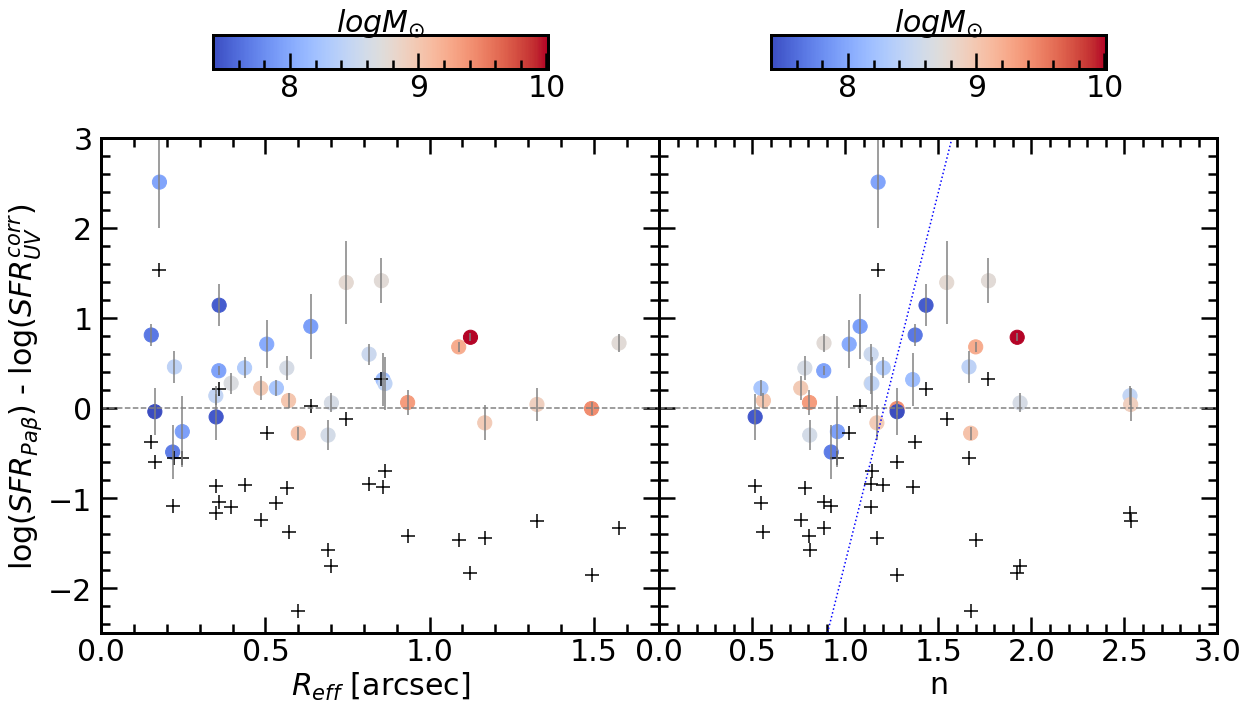

In [12]:
fig = plt.figure(figsize = (20 , 11))
gs = GridSpec(nrows=12, ncols=10)
gs.update(wspace = 0, hspace = 0.5)

ax0 = fig.add_subplot(gs[2:12, 0:5])
ax0.set_ylabel(r'log($SFR_{Pa\beta}$) - log($SFR_{UV}^{corr}$)')
ax0.set_xlabel(r"$R_{eff}$ [arcsec]")
y0 = ax0.scatter(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , s = 200 , c = fullmergedf['td_lmass'][fullmergedf['gf_f_j'] == 0] , cmap = 'coolwarm')
ax0.errorbar(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , yerr = fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , c = 'gray',  linestyle = 'None')
ax0.scatter(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'][fullmergedf['gf_f_j'] == 0] , s = 200 , marker = '+' , c = 'black')
ax0.axis([0 , 1.7 , -2.5 , 3])
ax0.plot([0 , 2] , [0 , 0] , '--' , c = 'gray')

ax1 = fig.add_subplot(gs[2:12, 5:10])
y1= ax1.scatter(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , s = 200 , c = fullmergedf['td_lmass'][fullmergedf['gf_f_j'] == 0] , cmap = 'coolwarm')
ax1.errorbar(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , yerr = fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , c = 'gray',  linestyle = 'None')
ax1.scatter(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'][fullmergedf['gf_f_j'] == 0] , s = 200 , marker = '+' , c = 'black')
ax1.plot([0 , 8] , [0 , 0] , '--' , c = 'gray')
ax1.plot([0 , 8] , [8.20999145*0 - 9.91942436 , 8.20999145*8 - 9.91942436] , ':' , c = 'blue')

ax1.set_xlabel(r"n")
ax1.axis([0 , 3 , -2.5 , 3])
ax1.tick_params(labelleft = False)

ax3 = fig.add_subplot(gs[0:1,1:4])
fig.colorbar(y0,ax3,use_gridspec=True,orientation='horizontal' ,  label = '$logM_{\odot}$')
ax3.xaxis.set_label_position('top')
ax4 = fig.add_subplot(gs[0:1,6:9])
fig.colorbar(y1,ax4,use_gridspec=True,orientation='horizontal' ,  label = '$logM_{\odot}$')
ax4.xaxis.set_label_position('top')

plt.show()

In [13]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y ~ x', dict(x=fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , y=fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0]), family=family)
    trace_robust = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.


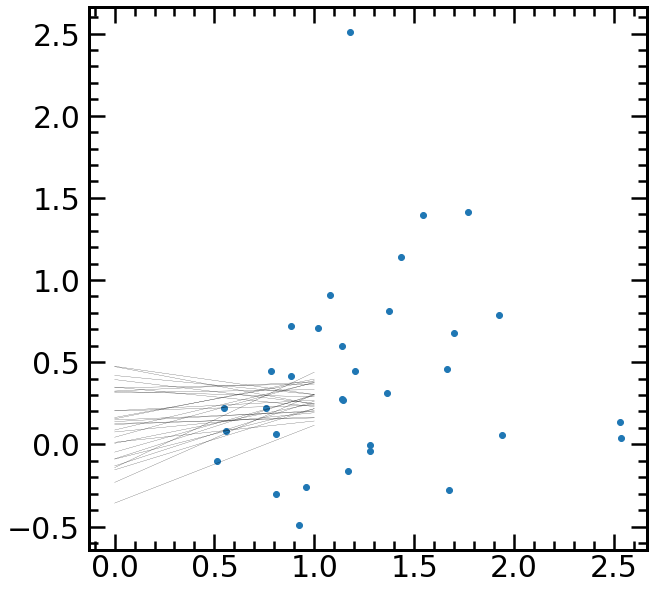

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0])
pm.plot_posterior_predictive_glm(trace_robust)
plt.title("")
plt.show()

In [15]:
pm.summary(trace_robust)

C:\Users\nikko\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.138,0.224,-0.267,0.546,0.009,0.006,626.0,626.0,634.0,631.0,1.0
x,0.135,0.196,-0.177,0.526,0.008,0.006,581.0,545.0,598.0,656.0,1.0
lam,11.170,4.820,4.046,20.574,0.187,0.147,666.0,542.0,793.0,696.0,1.0
